# Use the DR10 data and Covariance Matrix to constrain $b$ and $\Omega_bh^2$ using pycamb

## Part to define the libraries and read the DR10 data

In [1]:
#Part to fit some theoritical correlation functions


%matplotlib inline
import sys, platform, os
from matplotlib import pyplot as plt
import numpy as np
import scipy as sp
#uncomment this if you are running remotely and want to keep in synch with repo changes
#if platform.system()!='Windows':
#    !cd $HOME/git/camb; git pull github master; git log -1
print('Using CAMB installed at '+ os.path.realpath(os.path.join(os.getcwd(),'..')))
sys.path.insert(0,os.path.realpath(os.path.join(os.getcwd(),'..')))

import camb
from camb import model, initialpower

import scipy.integrate as integrate
import scipy.special as special
from scipy.interpolate import interp1d
##Read the data : xi(r) and covariance matrix

r, xi0, xi2 = np.loadtxt('Anderson_2013_CMASSDR10_corfun_x0x2_postrecon.txt')
rcut = 46.
ind_cut = int(np.argmin(abs(r-rcut)))
nbb = len(r[ind_cut :])
tab_bins = r[ind_cut :]
tab_xi0 = xi0[ind_cut :]

tab_cov_xi0  =np.loadtxt('tab_cov_xi0_DR10.txt')
tab_bins = np.loadtxt('tab_bins_DR10.txt')
cov_mat = np.matrix(tab_cov_xi0)
#print cov_mat.I
cov_inv = cov_mat.I

nbb = len(tab_bins)

tab_err_xi0 = np.zeros(nbb)

###Part to store the diagonal terms of the covariance matrix (just to plot it)
for i in range(0,nbb):
    tab_err_xi0[i] = tab_cov_xi0[i,i]


vals_err = np.power(tab_bins,2)*np.sqrt(tab_err_xi0)
vals_measure = np.power(tab_bins,2)*tab_xi0    








Using CAMB installed at /Users/sebinouf/Dossiers


## Part to evaluate the $\chi^2$ values over 2 parameters : the linear bias and $\Omega_bh^2$ 

In [2]:

####Definition of the parameter we want to constrain

bias_min=0.5
bias_max= 5.
nb_bias = 100

tab_bias = np.linspace(bias_min, bias_max, nb_bias)

obh2_min = 0.001
obh2_max = 0.030
nb_obh2 = 30
tab_obh2 = np.linspace(obh2_min, obh2_max, nb_obh2)


##Chi2 array definition (in whiwh we will store the values of the chi2 estimation)
tab_chi2 = np.zeros( (nb_obh2, nb_bias) )
tab_chi2_cov = np.zeros((nb_obh2, nb_bias))


for indx in range(nb_obh2):

    pars = camb.CAMBparams()
    pars.set_cosmology(H0=67.5, ombh2=tab_obh2[indx], omch2=0.122)
    pars.set_dark_energy() #re-set defaults
    pars.InitPower.set_params(ns=0.965)
    #Not non-linear corrections couples to smaller scales than you want
    pars.set_matter_power(redshifts=[ 0.55], kmax=10.0)

    #Linear spectra
    #pars.NonLinear = model.NonLinear_none
    #Non-Linear spectra
    pars.NonLinear = model.NonLinear_none
    results = camb.get_results(pars)
    kh, z, pk = results.get_matter_power_spectrum(minkh=1e-4, maxkh=10, npoints = 5000)
    s8 = np.array(results.get_sigma8())

    
    #####PART TO CALCULATE THE FOURIER TRANSFORM OF THE P(k) => Xi(r)
    xi = np.zeros(nbb)

    #np.savetxt('tab_cov_xi0_DR10.txt',  tab_cov_xi0 )
    #np.savetxt('tab_bins_DR10.txt', tab_bins)

    kstart = 0
    kcut = 10
    kcut_ind = np.argmin( abs(kh - kcut))

    factor = np.power(kh[kstart:kcut_ind],2) * pk[0,kstart:kcut_ind] / (kh[kstart:kcut_ind]*2*np.pi**2)
    for i in range(0, nbb):
            IntegrandXi0 = factor * np.sin(kh[kstart:kcut_ind]*tab_bins[i]) / tab_bins[i]
            xi[i] = np.trapz(IntegrandXi0,kh[kstart:kcut_ind])


        
    





    for i in range(0, nb_bias):
        vals_mod = np.power(tab_bins,2)*xi*tab_bias[i]**2
        vals_mod_cov = xi*tab_bias[i]**2
        tab_chi2[indx, i] = np.sum( np.power((vals_mod - vals_measure)/vals_err,2)  )
        tab_chi2_cov[indx, i] = np.dot( vals_mod_cov-tab_xi0 , np.dot( cov_inv , (vals_mod_cov.reshape( nbb,1)-tab_xi0.reshape(nbb,1) ) ) )


        
####Obtain the the best_fit parameters values and compare the best_chi^2 value obtain to the cumulative 
t_min = np.unravel_index(tab_chi2_cov.argmin(), tab_chi2_cov.shape )
##Right now we have the Chi^2 for the all parameters values
        

## Part to check if the best fit have a correct $\chi^2$ value

In [21]:
#Values for 1,2 and 3 sigma for a gaussian
val1=0.68268949  
val2=0.95449974  
val3=0.9973002

vals = np.zeros(3)
vals[0] = val1
vals[1] = val2
vals[2] = val3

index_sig = np.zeros(3, int)


dof = nbb-2   ##we have 2 parameters and nbb bins of points
nbs = 1000
tab_val = np.linspace(1,60, nbs)
tab_gi = np.zeros(nbs)
for i in range(len(tab_val)):
    tab_gi[i] = sp.special.gammainc(dof/2.,tab_val[i]/2)

for i in range(len(vals)):
    index_sig[i] =  int(round(np.argmin( abs(tab_gi - vals[i]) )) )


print "Indices corresponding to the contours =", index_sig

levels = tab_val[index_sig]
print 'levels at 1, 2 and 3 $\sigma$ =',levels




Indices corresponding to the contours = [326 478 646]
levels at 1, 2 and 3 $\sigma$ = [ 20.25325325  29.23023023  39.15215215]


## Part to calculate the Hessian  matrix of the chi^2 (ie the Fisher matrix at a factor 2)

In [22]:

####Part to calculate the Hessian  matrix of the chi^2 (ie the Fisher matrix at a factor 2)

delta_obh2 = tab_obh2[1] - tab_obh2[0]
delta_bias = tab_bias[1] - tab_bias[0]

matrix_2nd_der = np.zeros( (2,2) )

matrix_2nd_der[0,0] = (tab_chi2[t_min[0]+2, t_min[1]] - 2*tab_chi2[t_min[0], t_min[1]] + tab_chi2[t_min[0]-2, t_min[1] ])/(4*delta_obh2**2)
matrix_2nd_der[1,1] = (tab_chi2[t_min[0], t_min[1]+2 ] - 2*tab_chi2[t_min[0], t_min[1]] + tab_chi2[t_min[0], t_min[1]-2 ])/(4*delta_bias**2)

matrix_2nd_der[0,1] = (tab_chi2[t_min[0]+1, t_min[1]+1 ] - tab_chi2[t_min[0]-1, t_min[1]+1] - tab_chi2[t_min[0]+1, t_min[1]-1] + tab_chi2[t_min[0]-1, t_min[1]-1]  )/(4.*delta_obh2*delta_bias)
matrix_2nd_der[1,0] = matrix_2nd_der[0,1]






## plot of the 2nd order approximation of the $\Delta\chi^2$ values and compare with the reel one

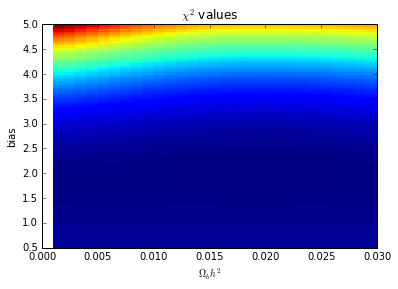

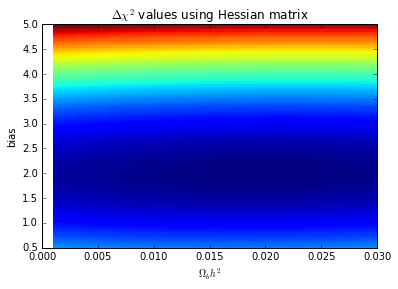

In [23]:
##Part to compute the 2nd order polynome which fit the best fit region in order to apply the Delta_chi2 table on it

tab_approx_delta_chi2 = np.zeros( (nb_obh2, nb_bias) )
for i in range(nb_obh2):
    for j in range(nb_bias):
        vec_delta=np.array([ tab_obh2[i]-tab_obh2[t_min[0]] , tab_bias[j]-tab_bias[t_min[1]]])
        tab_approx_delta_chi2[i,j] = 0.5* np.dot( vec_delta, np.dot( np.transpose(matrix_2nd_der) , vec_delta.reshape(2,1) ) )

        
plt.pcolormesh(tab_obh2, tab_bias, np.transpose(tab_chi2_cov))
plt.title('$\chi^2$ values')
plt.xlabel('$\Omega_bh^2$')
plt.ylabel('bias')
plt.show()

plt.pcolormesh(tab_obh2, tab_bias, np.transpose(tab_approx_delta_chi2))
plt.title('$\Delta\chi^2$ values using Hessian matrix')
plt.xlabel('$\Omega_bh^2$')
plt.ylabel('bias')
plt.show()




## Part to plot the contours and compare the results

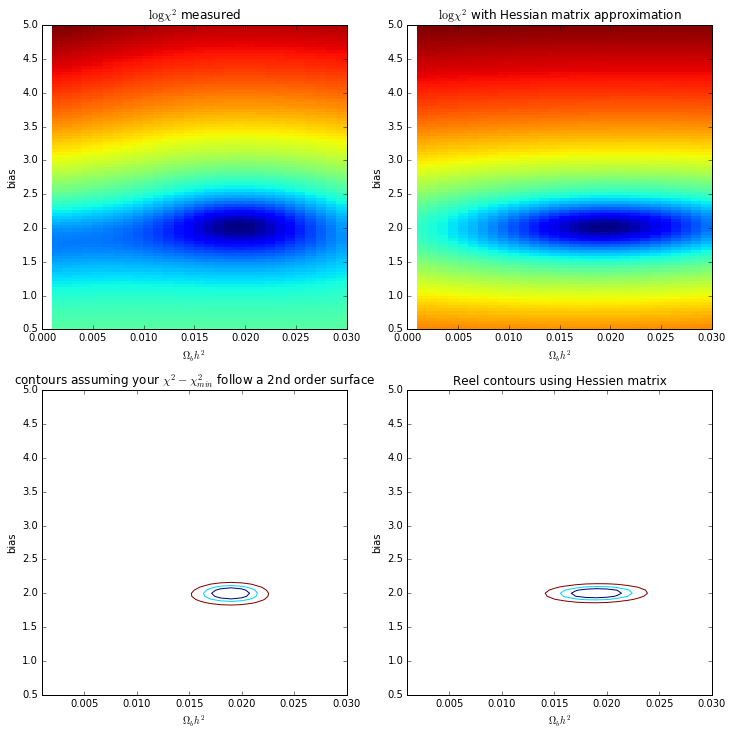

In [24]:
fig, ax = plt.subplots(2,2, figsize=(12,12))


ax[0,0].pcolormesh(tab_obh2, tab_bias, np.log10(np.transpose(tab_chi2_cov)) )
ax[0,0].set_title('$\log{\chi^2}$ measured')
ax[0,0].set_xlabel('$\Omega_b h^2$')
ax[0,0].set_ylabel('bias')
#ax[0,0].colorbar()


ax[0,1].pcolormesh(tab_obh2, tab_bias, np.log10( np.transpose(tab_approx_delta_chi2)+tab_chi2_cov.min() ))
ax[0,1].set_title('$\log{\chi^2}$ with Hessian matrix approximation')
ax[0,1].set_xlabel('$\Omega_b h^2$')
ax[0,1].set_ylabel('bias')
#ax[0,1].colorbar()

###Plot the contours for the 

#Delta chi2 for 2 parameters
val68=2.30
val90=4.61
val99=9.21
levs = np.array([val68, val90, val99])



ax[1,1].contour(tab_obh2, tab_bias, np.transpose(tab_approx_delta_chi2), levs )
ax[1,1].set_title('Reel contours using Hessien matrix')
ax[1,1].set_xlabel('$\Omega_b h^2$')
ax[1,1].set_ylabel('bias')
#plt.show()

ax[1,0].contour(tab_obh2, tab_bias, np.transpose(tab_chi2_cov - tab_chi2_cov.min()), levs )
ax[1,0].set_title('contours assuming your $\chi^2 - \chi^2_{min}$ follow a 2nd order surface')
ax[1,0].set_xlabel('$\Omega_b h^2$')
ax[1,0].set_ylabel('bias')


plt.show()

